Some imports

In [1]:
from deeppavlov.models.embedders.elmo_embedder import ELMoEmbedder
import pandas as pd
import re
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from bpemb import BPEmb

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Bidirectional
from keras.callbacks import ModelCheckpoint
from keras import backend as K

%matplotlib inline

[nltk_data] Downloading package punkt to /home/rdalex/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/rdalex/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package perluniprops to
[nltk_data]     /home/rdalex/nltk_data...
[nltk_data]   Package perluniprops is already up-to-date!
[nltk_data] Downloading package nonbreaking_prefixes to
[nltk_data]     /home/rdalex/nltk_data...
[nltk_data]   Package nonbreaking_prefixes is already up-to-date!
Using TensorFlow backend.


Load the data

In [2]:
negative = pd.read_csv('data/negative.csv', header=None, sep=';', usecols=[3])
negative['class'] = 0
positive = pd.read_csv('data/positive.csv', header=None, sep=';', usecols=[3])
positive['class'] = 1
df = pd.concat([negative, positive], ignore_index=True, copy=False)
df = df.sample(frac=1).reset_index(drop=True)
df.rename(columns={3: 'text'}, inplace=True)
df.head(n=5)

,text,class
0,"Договорился с пацаном катнуть на мотоциклах, к...",1
1,"Ты цел?))))))) ""@leo_about_leo: Боги, кто бы м...",1
2,Наконец то я дома! Закончился рабочий день:) Д...,1
3,Суджу опять Новый год не дома встретят :(\nНО ...,0
4,"Муж жене: -Какого тёща приежает? -Каого что, Ч...",0


Preprocess sentences

In [3]:
def preprocess_text(text):
    # Lower text
    text = text.lower()
    # Remove URLs
    text = re.sub(r"http\S+", "", text)
    # Remove @ mentions
    text = re.sub(r"@\S+", "", text)
    # Remove hashtags
    text = re.sub(r"#\S+", "", text)
    # Remove rt (retweets)
    text = re.sub("rt", "", text)
    # Remove unneeded symbols
    text = re.sub(r"[/~/`/@/#/$/%/&/-/_/+/,/.]", "", text)
    # Remove extra spaces
    text = re.sub(" +", ' ', text)
    
    return text

In [4]:
df['preprocessed_text'] = df['text'].apply(lambda x: preprocess_text(x))
df.head()

,text,class,preprocessed_text
0,"Договорился с пацаном катнуть на мотоциклах, к...",1,договорился с пацаном катнуть на мотоциклах ко...
1,"Ты цел?))))))) ""@leo_about_leo: Боги, кто бы м...",1,"ты цел?))))))) "" боги кто бы мог подумать что ..."
2,Наконец то я дома! Закончился рабочий день:) Д...,1,наконец то я дома! закончился рабочий день:) д...
3,Суджу опять Новый год не дома встретят :(\nНО ...,0,суджу опять новый год не дома встретят :(\nно ...
4,"Муж жене: -Какого тёща приежает? -Каого что, Ч...",0,муж жене: -какого тёща приежает? -каого что чи...


Load BPE model

In [8]:
bpe = BPEmb(lang='ru', vs=30000)
print(bpe.encode('Привет, ну как ты там поживаешь? :) Слышал, что у тебя были недавно серьёзные проблемы'))

BPEmb fallback: ru from vocab size 30000 to 200000
['▁привет', ',', '▁ну', '▁как', '▁ты', '▁там', '▁по', 'жива', 'ешь', '?', '▁:', ')', '▁слышал', ',', '▁что', '▁у', '▁тебя', '▁были', '▁недавно', '▁серьёзные', '▁проблемы']


Translate tokenized text to indices in embedding dictionary

In [9]:
def text_data_to_tokens(texts):
    res = []
    for txt in texts:
        tokenized_txt = bpe.encode(txt)
        replaced_by_num = [bpe.emb.vocab[word].index for word in tokenized_txt if word in bpe.emb.vocab]
        res.append(replaced_by_num)
    return res

In [11]:
X = text_data_to_tokens(list(df['preprocessed_text']))
print(X[:2])

[[68777, 6, 80907, 206, 23579, 7094, 35, 116017, 1097, 53, 2888, 114229, 199947, 34878], [1032, 161239, 9948, 11211, 11211, 11211, 1318, 11380, 3492, 96, 4604, 82912, 219, 8628, 3, 1318, 78121, 24147, 199974, 8946, 18111, 2457, 1913, 59585]]


Train/test split

In [12]:
data_train, data_test, label_train, label_test = train_test_split(
    X,
    df['class'],
    test_size=0.2,
    shuffle=True,
    random_state=42
)

Longest sentence length

In [13]:
max([len(x) for x in X])

131

Embedding layer params

In [14]:
bpe.emb.get_keras_embedding().get_config()

{'name': 'embedding_1',
 'trainable': False,
 'batch_input_shape': (None, None),
 'dtype': 'float32',
 'input_dim': 200000,
 'output_dim': 100,
 'embeddings_initializer': {'class_name': 'RandomUniform',
  'config': {'minval': -0.05, 'maxval': 0.05, 'seed': None}},
 'embeddings_regularizer': None,
 'activity_regularizer': None,
 'embeddings_constraint': None,
 'mask_zero': False,
 'input_length': None}

In [15]:
def precision(y_true, y_pred):
    """Precision metric.

    Only computes a batch-wise average of precision.

    Computes the precision, a metric for multi-label classification of
    how many selected items are relevant.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


def recall(y_true, y_pred):
    """Recall metric.

    Only computes a batch-wise average of recall.

    Computes the recall, a metric for multi-label classification of
    how many relevant items are selected.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall


def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))

Training

In [16]:
maxlen = 150
batch_size = 256
epochs = 30

X_train = sequence.pad_sequences(data_train, maxlen=maxlen)
X_test = sequence.pad_sequences(data_test, maxlen=maxlen)
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)
y_train = np.array(label_train)
y_test = np.array(label_test)

model = Sequential()
model.add(bpe.emb.get_keras_embedding())
model.add(Bidirectional(LSTM(150)))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

callbacks = [ModelCheckpoint(filepath='trained_models/bpe_bilstm.h5', 
                             monitor='val_loss', 
                             save_best_only=True)
            ]
model.compile('adadelta', 'binary_crossentropy', metrics=[precision, recall, f1])
history = model.fit(
    X_train, 
    y_train, 
    batch_size=batch_size, 
    epochs=epochs, 
    validation_split=0.1, 
    callbacks=callbacks
)

X_train shape: (181467, 150)
X_test shape: (45367, 150)









Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 163320 samples, validate on 18147 samples
Epoch 1/30
163320/163320 [==============================] - 226s 1ms/step - loss: 0.1582 - precision: 0.9224 - recall: 0.9596 - f1: 0.9389 - val_loss: 0.0671 - val_precision: 0.9705 - val_recall: 0.9866 - val_f1: 0.9784
Epoch 2/30
163320/163320 [==============================] - 224s 1ms/step - loss: 0.0496 - precision: 0.9784 - recall: 0.9885 - f1: 0.9833 - val_loss: 0.0346 - val_precision: 0.9874 - val_recall: 0.9919 - val_f1: 0.9896
Epoch 3/30
163320/163320 [==============================] - 224s 1ms/step - loss: 0.0276 - precision: 0.9901 - recall: 0.9923 - f1: 0.9911 - val_loss: 0.0218 - val_precision: 0.9930 - val_recall: 0.9940 - val_f1: 0.9935
Epoch 4/30


Epoch 23/30
163320/163320 [==============================] - 223s 1ms/step - loss: 0.0037 - precision: 0.9992 - recall: 0.9985 - f1: 0.9988 - val_loss: 0.0116 - val_precision: 0.9980 - val_recall: 0.9964 - val_f1: 0.9972
Epoch 24/30
163320/163320 [==============================] - 223s 1ms/step - loss: 0.0034 - precision: 0.9992 - recall: 0.9988 - f1: 0.9990 - val_loss: 0.0117 - val_precision: 0.9974 - val_recall: 0.9970 - val_f1: 0.9972
Epoch 25/30
163320/163320 [==============================] - 223s 1ms/step - loss: 0.0031 - precision: 0.9992 - recall: 0.9988 - f1: 0.9990 - val_loss: 0.0135 - val_precision: 0.9960 - val_recall: 0.9974 - val_f1: 0.9967
Epoch 26/30
163320/163320 [==============================] - 223s 1ms/step - loss: 0.0031 - precision: 0.9992 - recall: 0.9988 - f1: 0.9990 - val_loss: 0.0122 - val_precision: 0.9977 - val_recall: 0.9967 - val_f1: 0.9972
Epoch 27/30
163320/163320 [==============================] - 223s 1ms/step - loss: 0.0028 - precision: 0.9993 - reca

In [17]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 100)         20000000  
_________________________________________________________________
bidirectional_1 (Bidirection (None, 300)               301200    
_________________________________________________________________
dropout_1 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 301       
Total params: 20,301,501
Trainable params: 301,501
Non-trainable params: 20,000,000
_________________________________________________________________


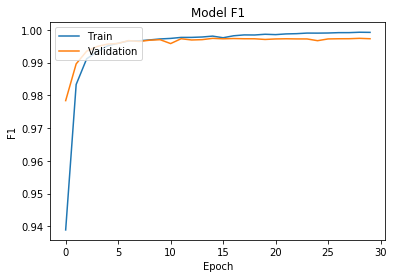

In [18]:
plt.plot(history.history['f1'])
plt.plot(history.history['val_f1'])
plt.title('Model F1')
plt.ylabel('F1')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

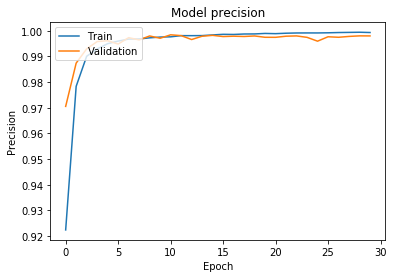

In [19]:
plt.plot(history.history['precision'])
plt.plot(history.history['val_precision'])
plt.title('Model precision')
plt.ylabel('Precision')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

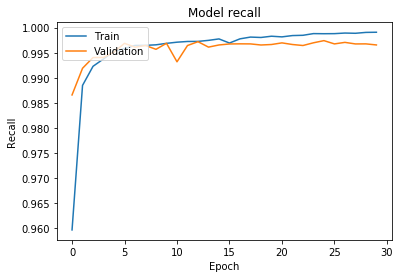

In [20]:
plt.plot(history.history['recall'])
plt.plot(history.history['val_recall'])
plt.title('Model recall')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

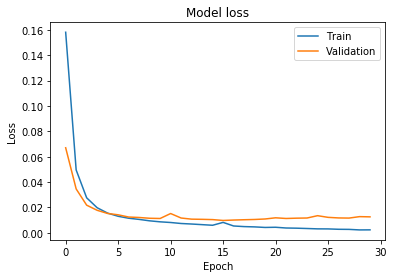

In [21]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [22]:
print(classification_report(y_test, model.predict_classes(X_test)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     22301
           1       1.00      1.00      1.00     23066

    accuracy                           1.00     45367
   macro avg       1.00      1.00      1.00     45367
weighted avg       1.00      1.00      1.00     45367

